# NBA Handicap Spread Coverage Network Rating

## Objective
Build network-based strength ratings using **handicap-adjusted spread coverage**.
This applies an 11-point cushion from each team's perspective to identify:
- **Cushion-Dependent Teams**: Need the handicap to cover
- **Cushion-Proof Teams**: Cover comfortably regardless of handicap

## Key Concept
- Home covers with handicap if: `spread_result_diff >= -11`
- Away covers with handicap if: `spread_result_diff <= 11`
- Games within ±11 points → both teams "cover with handicap"
- Network edge goes to team with larger handicap-adjusted margin

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

# NBA Handicap Spread Config
CONFIG = {
    'sport': 'NBA',
    'handicap': 11,          # Point cushion applied to each team
    'margin_cap': 10,        # ~2 possessions max impact (NBA scoring pace)
    'recency_decay': 0.95,
    'learning_rate': 0.05,
    'iterations': 100,
    'tolerance': 0.001
}

print(f"Handicap Spread Config: {CONFIG}")

Handicap Spread Config: {'sport': 'NBA', 'handicap': 11, 'margin_cap': 10, 'recency_decay': 0.95, 'learning_rate': 0.05, 'iterations': 100, 'tolerance': 0.001}


## Phase 1: Data Loading

In [2]:
# Load NBA data
data_file = Path().resolve().parent / 'data' / 'results' / 'nba_season_results.xlsx'
df = pd.read_excel(data_file)

print(f"Loaded {len(df)} NBA games")
print(f"Date range: {df['game_date'].min().date()} to {df['game_date'].max().date()}")

# Filter to games with spread data
df_spread = df[df['spread_result_difference'].notna()].copy()
print(f"\nGames with spread data: {len(df_spread)}")

# Get all teams
all_teams = set(df_spread['home_team'].unique()) | set(df_spread['away_team'].unique())
print(f"Total teams: {len(all_teams)}")

df_spread.head()

Loaded 537 NBA games
Date range: 2025-10-21 to 2026-01-05

Games with spread data: 537
Total teams: 30


,game_date,home_team,away_team,closing_spread,home_score,away_score,spread_result_difference
0,2025-10-21,Oklahoma City Thunder,Houston Rockets,-6.5,125,124,-5.5
1,2025-10-21,Los Angeles Lakers,Golden State Warriors,2.5,109,119,-7.5
2,2025-10-22,Orlando Magic,Miami Heat,-8.5,125,121,-4.5
3,2025-10-22,Atlanta Hawks,Toronto Raptors,-5.5,118,138,-25.5
4,2025-10-22,Chicago Bulls,Detroit Pistons,3.5,115,111,7.5


## Phase 2: Handicap-Adjusted Cover Determination

In [3]:
handicap = CONFIG['handicap']

# Calculate handicap-adjusted margins from each team's perspective
df_spread['home_margin_handicap'] = df_spread['spread_result_difference'] + handicap
df_spread['away_margin_handicap'] = handicap - df_spread['spread_result_difference']

# Determine if each team covers with the handicap
df_spread['home_covers_handicap'] = df_spread['spread_result_difference'] >= -handicap
df_spread['away_covers_handicap'] = df_spread['spread_result_difference'] <= handicap

# For network: cover_team is the one with larger handicap-adjusted margin
df_spread['cover_team'] = np.where(
    df_spread['home_margin_handicap'] >= df_spread['away_margin_handicap'],
    df_spread['home_team'],
    df_spread['away_team']
)
df_spread['fail_team'] = np.where(
    df_spread['home_margin_handicap'] >= df_spread['away_margin_handicap'],
    df_spread['away_team'],
    df_spread['home_team']
)
df_spread['cover_margin'] = np.maximum(
    df_spread['home_margin_handicap'],
    df_spread['away_margin_handicap']
)

# Summary statistics
print(f"Handicap Analysis ({handicap}pt cushion):")
print(f"  Games where BOTH teams cover with handicap: {(df_spread['home_covers_handicap'] & df_spread['away_covers_handicap']).sum()}")
print(f"  Games where only home covers: {(df_spread['home_covers_handicap'] & ~df_spread['away_covers_handicap']).sum()}")
print(f"  Games where only away covers: {(~df_spread['home_covers_handicap'] & df_spread['away_covers_handicap']).sum()}")
print(f"  Games where neither covers: {(~df_spread['home_covers_handicap'] & ~df_spread['away_covers_handicap']).sum()}")

df_spread[['game_date', 'home_team', 'away_team', 'spread_result_difference', 
           'home_margin_handicap', 'away_margin_handicap', 'cover_team', 'cover_margin']].head(10)

Handicap Analysis (11pt cushion):
  Games where BOTH teams cover with handicap: 322
  Games where only home covers: 110
  Games where only away covers: 105
  Games where neither covers: 0


,game_date,home_team,away_team,spread_result_difference,home_margin_handicap,away_margin_handicap,cover_team,cover_margin
0,2025-10-21,Oklahoma City Thunder,Houston Rockets,-5.5,5.5,16.5,Houston Rockets,16.5
1,2025-10-21,Los Angeles Lakers,Golden State Warriors,-7.5,3.5,18.5,Golden State Warriors,18.5
2,2025-10-22,Orlando Magic,Miami Heat,-4.5,6.5,15.5,Miami Heat,15.5
3,2025-10-22,Atlanta Hawks,Toronto Raptors,-25.5,-14.5,36.5,Toronto Raptors,36.5
4,2025-10-22,Chicago Bulls,Detroit Pistons,7.5,18.5,3.5,Chicago Bulls,18.5
5,2025-10-22,Boston Celtics,Philadelphia 76ers,-6.5,4.5,17.5,Philadelphia 76ers,17.5
6,2025-10-22,Milwaukee Bucks,Washington Wizards,2.5,13.5,8.5,Milwaukee Bucks,13.5
7,2025-10-22,New York Knicks,Cleveland Cavaliers,9.5,20.5,1.5,New York Knicks,20.5
8,2025-10-22,Memphis Grizzlies,New Orleans Pelicans,2.5,13.5,8.5,Memphis Grizzlies,13.5
9,2025-10-22,Dallas Mavericks,San Antonio Spurs,-37.5,-26.5,48.5,San Antonio Spurs,48.5


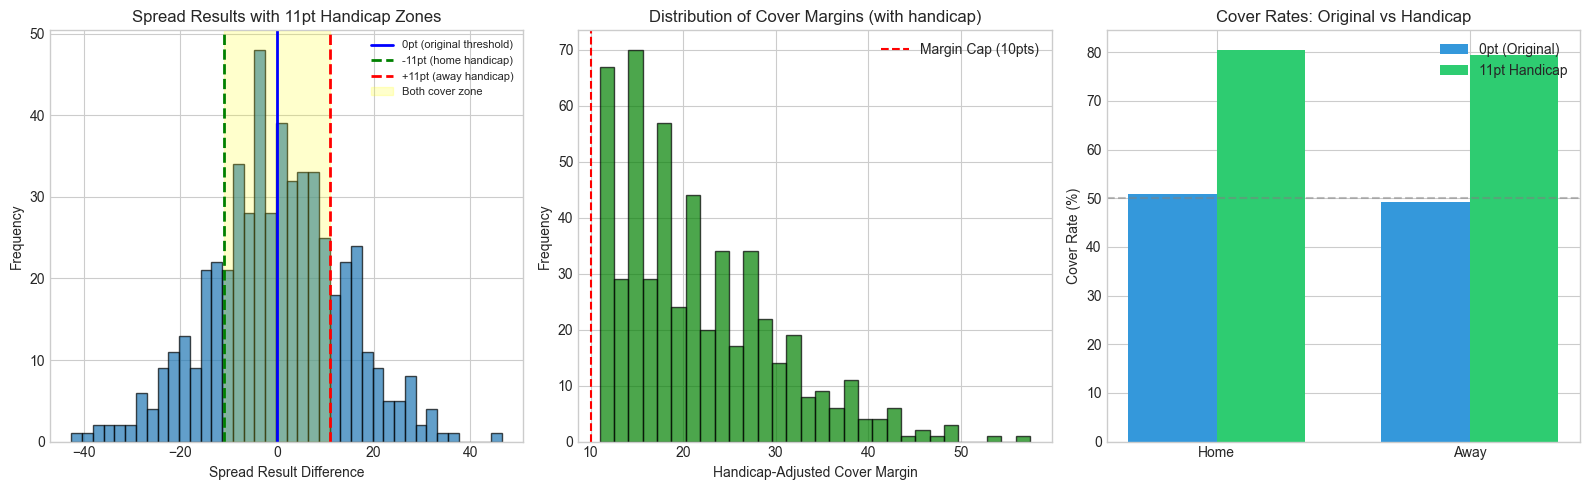


Original Cover Rates: Home 50.8%, Away 49.2%
Handicap Cover Rates: Home 80.4%, Away 79.5%


In [4]:
# Visualize handicap coverage distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Original spread result distribution with handicap thresholds
ax = axes[0]
ax.hist(df_spread['spread_result_difference'], bins=40, edgecolor='black', alpha=0.7)
ax.axvline(x=0, color='blue', linestyle='-', linewidth=2, label='0pt (original threshold)')
ax.axvline(x=-handicap, color='green', linestyle='--', linewidth=2, label=f'-{handicap}pt (home handicap)')
ax.axvline(x=handicap, color='red', linestyle='--', linewidth=2, label=f'+{handicap}pt (away handicap)')
ax.axvspan(-handicap, handicap, alpha=0.2, color='yellow', label='Both cover zone')
ax.set_xlabel('Spread Result Difference')
ax.set_ylabel('Frequency')
ax.set_title(f'Spread Results with {handicap}pt Handicap Zones')
ax.legend(fontsize=8)

# Cover margin distribution (handicap-adjusted)
ax = axes[1]
ax.hist(df_spread['cover_margin'], bins=30, edgecolor='black', alpha=0.7, color='green')
ax.axvline(x=CONFIG['margin_cap'], color='r', linestyle='--', label=f"Margin Cap ({CONFIG['margin_cap']}pts)")
ax.set_xlabel('Handicap-Adjusted Cover Margin')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Cover Margins (with handicap)')
ax.legend()

# Compare: original vs handicap cover rates
ax = axes[2]
original_home_cover = (df_spread['spread_result_difference'] >= 0).mean() * 100
original_away_cover = (df_spread['spread_result_difference'] < 0).mean() * 100
handicap_home_cover = df_spread['home_covers_handicap'].mean() * 100
handicap_away_cover = df_spread['away_covers_handicap'].mean() * 100

x = np.arange(2)
width = 0.35
ax.bar(x - width/2, [original_home_cover, original_away_cover], width, label='0pt (Original)', color='#3498db')
ax.bar(x + width/2, [handicap_home_cover, handicap_away_cover], width, label=f'{handicap}pt Handicap', color='#2ecc71')
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
ax.set_xticks(x)
ax.set_xticklabels(['Home', 'Away'])
ax.set_ylabel('Cover Rate (%)')
ax.set_title('Cover Rates: Original vs Handicap')
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nOriginal Cover Rates: Home {original_home_cover:.1f}%, Away {original_away_cover:.1f}%")
print(f"Handicap Cover Rates: Home {handicap_home_cover:.1f}%, Away {handicap_away_cover:.1f}%")

## Phase 3: Build Handicap Network & Compute Ratings

In [5]:
def build_handicap_network(games_df, recency_decay=0.95):
    """
    Build weighted directed graph from handicap-adjusted spread coverage.
    Edge: cover_team -> fail_team (based on larger handicap margin)
    """
    G = nx.DiGraph()
    
    for team in all_teams:
        G.add_node(team)
    
    games_sorted = games_df.sort_values('game_date')
    max_date = games_sorted['game_date'].max()
    
    edge_data = {}
    
    for _, game in games_sorted.iterrows():
        cover_team = game['cover_team']
        fail_team = game['fail_team']
        cover_margin = game['cover_margin']
        
        days_ago = (max_date - game['game_date']).days
        recency_weight = recency_decay ** (days_ago / 7)
        
        key = (cover_team, fail_team)
        if key not in edge_data:
            edge_data[key] = {
                'games': 0,
                'total_margin': 0,
                'weighted_margin': 0,
                'total_weight': 0
            }
        
        edge_data[key]['games'] += 1
        edge_data[key]['total_margin'] += cover_margin
        edge_data[key]['weighted_margin'] += cover_margin * recency_weight
        edge_data[key]['total_weight'] += recency_weight
    
    for (cover_team, fail_team), data in edge_data.items():
        G.add_edge(cover_team, fail_team,
                   games=data['games'],
                   avg_margin=data['total_margin'] / data['games'],
                   weighted_margin=data['weighted_margin'] / data['total_weight'])
    
    return G

G_handicap = build_handicap_network(df_spread, CONFIG['recency_decay'])

print(f"Handicap Network Summary:")
print(f"  Nodes: {G_handicap.number_of_nodes()}")
print(f"  Edges: {G_handicap.number_of_edges()}")
print(f"  Density: {nx.density(G_handicap):.3f}")

Handicap Network Summary:
  Nodes: 30
  Edges: 419
  Density: 0.482


In [6]:
def compute_handicap_rating(games_df, max_iterations=100, tolerance=0.001, 
                            margin_cap=10, learning_rate=0.05):
    """
    Compute network-propagated handicap spread coverage ratings.
    """
    teams = set(games_df['home_team']) | set(games_df['away_team'])
    ratings = {team: 0.5 for team in teams}
    history = []
    
    for iteration in range(max_iterations):
        new_ratings = ratings.copy()
        
        for _, game in games_df.iterrows():
            cover_team = game['cover_team']
            fail_team = game['fail_team']
            cover_margin = min(game['cover_margin'], margin_cap)
            
            total = ratings[cover_team] + ratings[fail_team]
            expected = ratings[cover_team] / total if total > 0 else 0.5
            surprise = 1 - expected
            adjustment = surprise * (cover_margin / margin_cap) * learning_rate
            
            new_ratings[cover_team] += adjustment
            new_ratings[fail_team] -= adjustment
        
        min_r, max_r = min(new_ratings.values()), max(new_ratings.values())
        if max_r > min_r:
            new_ratings = {t: (r - min_r) / (max_r - min_r) for t, r in new_ratings.items()}
        
        max_change = max(abs(new_ratings[t] - ratings[t]) for t in teams)
        history.append(max_change)
        
        if max_change < tolerance:
            print(f"Converged at iteration {iteration + 1}")
            break
        
        ratings = new_ratings
    
    return ratings, history

handicap_ratings, convergence = compute_handicap_rating(
    df_spread,
    max_iterations=CONFIG['iterations'],
    tolerance=CONFIG['tolerance'],
    margin_cap=CONFIG['margin_cap'],
    learning_rate=CONFIG['learning_rate']
)

# Display top teams
handicap_df = pd.DataFrame([
    {'team': team, 'handicap_rating': rating}
    for team, rating in handicap_ratings.items()
]).sort_values('handicap_rating', ascending=False)

print("\nTop 10 Teams by Handicap Rating:")
print(handicap_df.head(10).to_string(index=False))


Top 10 Teams by Handicap Rating:
               team  handicap_rating
       Phoenix Suns         1.000000
Cleveland Cavaliers         0.521760
 Los Angeles Lakers         0.520480
          Utah Jazz         0.487704
     Boston Celtics         0.482312
     Denver Nuggets         0.481358
 Philadelphia 76ers         0.448532
         Miami Heat         0.433725
  San Antonio Spurs         0.410303
  Charlotte Hornets         0.400431


## Phase 4: Compare to Non-Handicap (0pt) Rating

In [7]:
# Compute original (0pt) spread coverage rating for comparison
df_original = df_spread.copy()
df_original['cover_team'] = np.where(
    df_original['spread_result_difference'] >= 0,
    df_original['home_team'],
    df_original['away_team']
)
df_original['fail_team'] = np.where(
    df_original['spread_result_difference'] >= 0,
    df_original['away_team'],
    df_original['home_team']
)
df_original['cover_margin'] = df_original['spread_result_difference'].abs()

original_ratings, _ = compute_handicap_rating(
    df_original,
    max_iterations=CONFIG['iterations'],
    tolerance=CONFIG['tolerance'],
    margin_cap=CONFIG['margin_cap'],
    learning_rate=CONFIG['learning_rate']
)

print("Original (0pt) spread ratings computed.")

Original (0pt) spread ratings computed.


In [8]:
# Build comparison dataframe
team_stats = []

for team in all_teams:
    home_games = df_spread[df_spread['home_team'] == team]
    away_games = df_spread[df_spread['away_team'] == team]
    total_games = len(home_games) + len(away_games)
    
    # Original cover stats
    orig_home_covers = (home_games['spread_result_difference'] >= 0).sum()
    orig_away_covers = (away_games['spread_result_difference'] < 0).sum()
    original_covers = orig_home_covers + orig_away_covers
    
    # Handicap cover stats
    hcap_home_covers = home_games['home_covers_handicap'].sum()
    hcap_away_covers = away_games['away_covers_handicap'].sum()
    handicap_covers = hcap_home_covers + hcap_away_covers
    
    team_stats.append({
        'team': team,
        'games': total_games,
        'original_covers': original_covers,
        'original_cover_pct': original_covers / total_games if total_games > 0 else 0,
        'handicap_covers': handicap_covers,
        'handicap_cover_pct': handicap_covers / total_games if total_games > 0 else 0,
        'original_rating': original_ratings.get(team, 0.5),
        'handicap_rating': handicap_ratings.get(team, 0.5)
    })

df_compare = pd.DataFrame(team_stats)

# Calculate key metrics
df_compare['handicap_delta'] = df_compare['handicap_rating'] - df_compare['original_rating']
df_compare['cover_pct_gain'] = df_compare['handicap_cover_pct'] - df_compare['original_cover_pct']

df_compare = df_compare.sort_values('handicap_delta', ascending=False)

print(f"Rating Comparison: Original (0pt) vs Handicap ({handicap}pt)")
print("="*90)
print(df_compare[['team', 'original_cover_pct', 'handicap_cover_pct', 'cover_pct_gain',
                  'original_rating', 'handicap_rating', 'handicap_delta']].to_string(index=False))

Rating Comparison: Original (0pt) vs Handicap (11pt)
                  team  original_cover_pct  handicap_cover_pct  cover_pct_gain  original_rating  handicap_rating  handicap_delta
    Los Angeles Lakers            0.575758            0.727273        0.151515         0.155816         0.520480        0.364664
Minnesota Timberwolves            0.416667            0.805556        0.388889         0.079787         0.325058        0.245270
Portland Trail Blazers            0.540541            0.783784        0.243243         0.207063         0.390517        0.183453
  New Orleans Pelicans            0.540541            0.783784        0.243243         0.225256         0.381688        0.156432
  Los Angeles Clippers            0.428571            0.742857        0.314286         0.000000         0.145073        0.145073
    Philadelphia 76ers            0.588235            0.911765        0.323529         0.313156         0.448532        0.135375
        Denver Nuggets            0.583333  

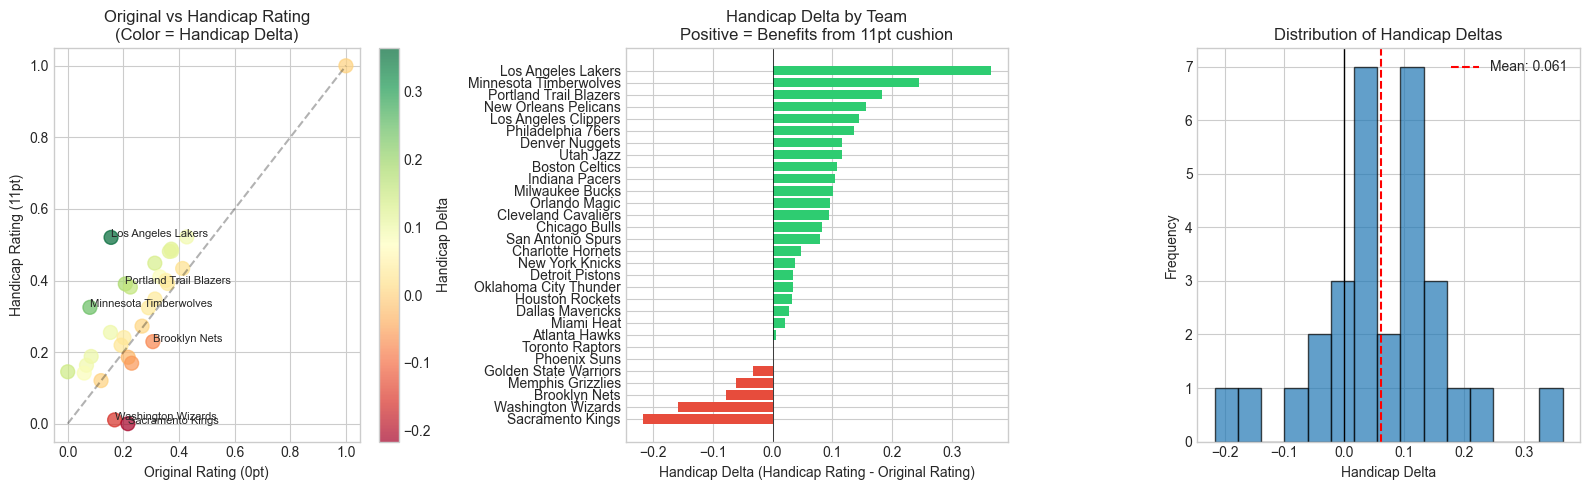

In [9]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Scatter: Original vs Handicap Rating
ax = axes[0]
scatter = ax.scatter(df_compare['original_rating'], df_compare['handicap_rating'],
                     c=df_compare['handicap_delta'], cmap='RdYlGn', s=100, alpha=0.7)
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Equal ratings')
ax.set_xlabel('Original Rating (0pt)')
ax.set_ylabel(f'Handicap Rating ({handicap}pt)')
ax.set_title('Original vs Handicap Rating\n(Color = Handicap Delta)')
fig.colorbar(scatter, ax=ax, label='Handicap Delta')

# Annotate extreme teams
for _, row in df_compare.head(3).iterrows():
    ax.annotate(row['team'], (row['original_rating'], row['handicap_rating']), fontsize=8)
for _, row in df_compare.tail(3).iterrows():
    ax.annotate(row['team'], (row['original_rating'], row['handicap_rating']), fontsize=8)

# Bar: Handicap Delta by Team
ax = axes[1]
sorted_df = df_compare.sort_values('handicap_delta')
colors = ['#e74c3c' if d < 0 else '#2ecc71' for d in sorted_df['handicap_delta']]
ax.barh(sorted_df['team'], sorted_df['handicap_delta'], color=colors)
ax.axvline(x=0, color='black', linewidth=0.5)
ax.set_xlabel('Handicap Delta (Handicap Rating - Original Rating)')
ax.set_title(f'Handicap Delta by Team\nPositive = Benefits from {handicap}pt cushion')

# Histogram of Handicap Deltas
ax = axes[2]
ax.hist(df_compare['handicap_delta'], bins=15, edgecolor='black', alpha=0.7)
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax.axvline(x=df_compare['handicap_delta'].mean(), color='red', linestyle='--', 
           label=f"Mean: {df_compare['handicap_delta'].mean():.3f}")
ax.set_xlabel('Handicap Delta')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Handicap Deltas')
ax.legend()

plt.tight_layout()
plt.show()

## Phase 5: Classify Teams (Cushion-Dependent vs Cushion-Proof)

In [10]:
# Classify teams based on handicap delta
delta_threshold = 0.03  # 3% rating change

cushion_dependent = df_compare[df_compare['handicap_delta'] > delta_threshold].sort_values('handicap_delta', ascending=False)
cushion_proof = df_compare[df_compare['handicap_delta'] < -delta_threshold].sort_values('handicap_delta')
neutral = df_compare[(df_compare['handicap_delta'] >= -delta_threshold) & 
                     (df_compare['handicap_delta'] <= delta_threshold)]

print("="*80)
print(f"TEAM CLASSIFICATION ({handicap}pt Handicap Analysis)")
print("="*80)

print(f"\n\U0001F7E1 CUSHION-DEPENDENT TEAMS ({len(cushion_dependent)} teams)")
print(f"These teams improve significantly with the {handicap}pt cushion.")
print("They may be underperforming against the spread but competitive in games.")
print("-"*80)
if len(cushion_dependent) > 0:
    print(cushion_dependent[['team', 'original_cover_pct', 'handicap_cover_pct', 
                             'original_rating', 'handicap_rating', 'handicap_delta']].to_string(index=False))

print(f"\n\U0001F7E2 CUSHION-PROOF TEAMS ({len(cushion_proof)} teams)")
print(f"These teams perform WORSE relative to others with the {handicap}pt cushion.")
print("They already cover convincingly - the cushion helps their opponents more.")
print("-"*80)
if len(cushion_proof) > 0:
    print(cushion_proof[['team', 'original_cover_pct', 'handicap_cover_pct', 
                         'original_rating', 'handicap_rating', 'handicap_delta']].to_string(index=False))

print(f"\n\U00002B1C NEUTRAL TEAMS ({len(neutral)} teams)")
print(f"These teams' relative rankings don't change much with the {handicap}pt cushion.")

TEAM CLASSIFICATION (11pt Handicap Analysis)

🟡 CUSHION-DEPENDENT TEAMS (20 teams)
These teams improve significantly with the 11pt cushion.
They may be underperforming against the spread but competitive in games.
--------------------------------------------------------------------------------
                  team  original_cover_pct  handicap_cover_pct  original_rating  handicap_rating  handicap_delta
    Los Angeles Lakers            0.575758            0.727273         0.155816         0.520480        0.364664
Minnesota Timberwolves            0.416667            0.805556         0.079787         0.325058        0.245270
Portland Trail Blazers            0.540541            0.783784         0.207063         0.390517        0.183453
  New Orleans Pelicans            0.540541            0.783784         0.225256         0.381688        0.156432
  Los Angeles Clippers            0.428571            0.742857         0.000000         0.145073        0.145073
    Philadelphia 76ers      

## Phase 6: Predictive Analysis

In [11]:
# Split data for predictive testing
df_sorted = df_spread.sort_values('game_date')
split_idx = int(len(df_sorted) * 0.75)

train_df = df_sorted.iloc[:split_idx].copy()
test_df = df_sorted.iloc[split_idx:].copy()

print(f"Training: {len(train_df)} games")
print(f"Testing: {len(test_df)} games")

# Compute handicap ratings on training data
train_df['cover_team'] = np.where(
    train_df['home_margin_handicap'] >= train_df['away_margin_handicap'],
    train_df['home_team'],
    train_df['away_team']
)
train_df['fail_team'] = np.where(
    train_df['home_margin_handicap'] >= train_df['away_margin_handicap'],
    train_df['away_team'],
    train_df['home_team']
)
train_df['cover_margin'] = np.maximum(train_df['home_margin_handicap'], train_df['away_margin_handicap'])

train_ratings, _ = compute_handicap_rating(train_df, margin_cap=CONFIG['margin_cap'])

# Calculate test period cover rates (with handicap)
test_cover_rates = {}
for team in all_teams:
    home_test = test_df[test_df['home_team'] == team]
    away_test = test_df[test_df['away_team'] == team]
    
    total = len(home_test) + len(away_test)
    if total > 0:
        covers = home_test['home_covers_handicap'].sum() + away_test['away_covers_handicap'].sum()
        test_cover_rates[team] = covers / total

# Correlation
pred_df = pd.DataFrame([
    {'team': t, 'train_rating': train_ratings.get(t, 0.5), 'test_cover': test_cover_rates.get(t, np.nan)}
    for t in all_teams if t in test_cover_rates
])

corr = pred_df['train_rating'].corr(pred_df['test_cover'])
print(f"\nPredictive Correlation (Training Handicap Rating vs Test Cover Rate): {corr:.3f}")

Training: 402 games
Testing: 135 games

Predictive Correlation (Training Handicap Rating vs Test Cover Rate): -0.189


/var/folders/jv/y3m0xwm544l00560wd0v47gh0000gn/T/ipykernel_5729/1191553898.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tier_cover = pred_df.groupby('tier')['test_cover'].mean()


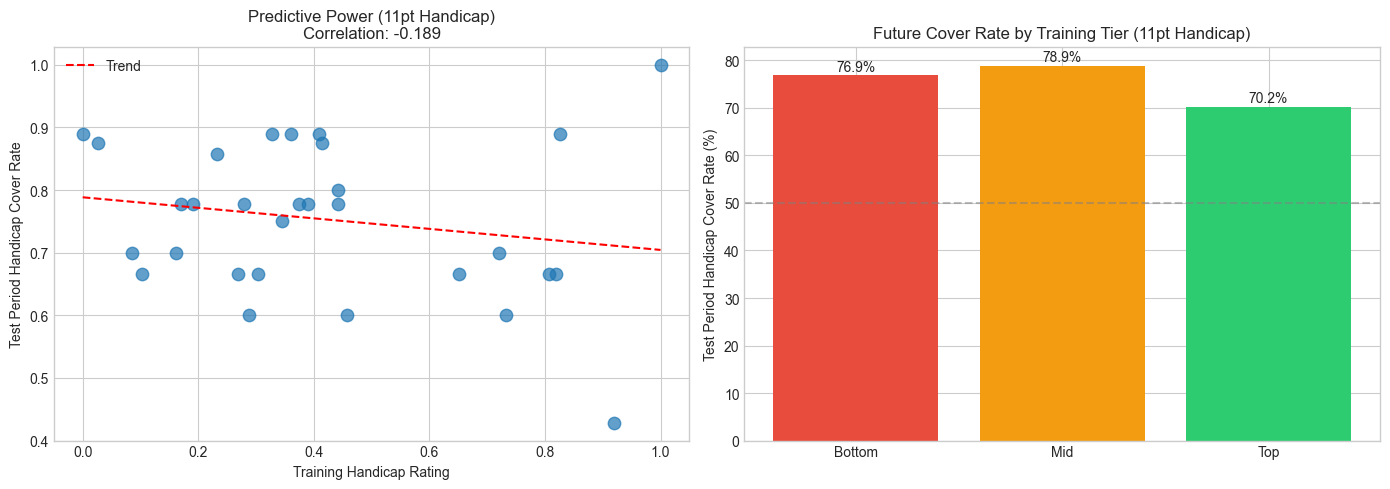

In [12]:
# Visualize predictive power
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.scatter(pred_df['train_rating'], pred_df['test_cover'], alpha=0.7, s=80)
ax.set_xlabel('Training Handicap Rating')
ax.set_ylabel('Test Period Handicap Cover Rate')
ax.set_title(f'Predictive Power ({handicap}pt Handicap)\nCorrelation: {corr:.3f}')

z = np.polyfit(pred_df['train_rating'], pred_df['test_cover'], 1)
p = np.poly1d(z)
ax.plot([0, 1], [p(0), p(1)], 'r--', label=f'Trend')
ax.legend()

# Tier analysis
ax = axes[1]
pred_df['tier'] = pd.qcut(pred_df['train_rating'], q=3, labels=['Bottom', 'Mid', 'Top'])
tier_cover = pred_df.groupby('tier')['test_cover'].mean()

colors = ['#e74c3c', '#f39c12', '#2ecc71']
bars = ax.bar(tier_cover.index, tier_cover.values * 100, color=colors)
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
ax.set_ylabel('Test Period Handicap Cover Rate (%)')
ax.set_title(f'Future Cover Rate by Training Tier ({handicap}pt Handicap)')

for bar, val in zip(bars, tier_cover.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val*100:.1f}%', ha='center')

plt.tight_layout()
plt.show()

## Summary

In [13]:
print("="*70)
print(f"NBA {handicap}PT HANDICAP SPREAD NETWORK ANALYSIS: SUMMARY")
print("="*70)

print(f"\n1. DATA")
print(f"   - Games analyzed: {len(df_spread)}")
print(f"   - Teams: {len(all_teams)}")
print(f"   - Handicap: {handicap} points")

print(f"\n2. COVER RATE CHANGES")
print(f"   - Original home cover rate: {original_home_cover:.1f}%")
print(f"   - Handicap home cover rate: {handicap_home_cover:.1f}%")
print(f"   - Games where both cover with handicap: {(df_spread['home_covers_handicap'] & df_spread['away_covers_handicap']).sum()}")

rating_corr = df_compare['original_rating'].corr(df_compare['handicap_rating'])
print(f"\n3. RATING CORRELATION")
print(f"   - Original vs Handicap rating correlation: {rating_corr:.3f}")
print(f"   - Mean handicap delta: {df_compare['handicap_delta'].mean():.4f}")
print(f"   - Std handicap delta: {df_compare['handicap_delta'].std():.4f}")

print(f"\n4. TEAM CLASSIFICATION")
print(f"   - Cushion-Dependent: {len(cushion_dependent)} teams")
print(f"   - Cushion-Proof: {len(cushion_proof)} teams")
print(f"   - Neutral: {len(neutral)} teams")

if len(cushion_dependent) > 0:
    top_dependent = cushion_dependent.iloc[0]
    print(f"   - Most cushion-dependent: {top_dependent['team']} (delta: +{top_dependent['handicap_delta']:.3f})")
if len(cushion_proof) > 0:
    top_proof = cushion_proof.iloc[0]
    print(f"   - Most cushion-proof: {top_proof['team']} (delta: {top_proof['handicap_delta']:.3f})")

print(f"\n5. PREDICTIVE POWER")
print(f"   - Training-to-Test correlation: {corr:.3f}")

NBA 11PT HANDICAP SPREAD NETWORK ANALYSIS: SUMMARY

1. DATA
   - Games analyzed: 537
   - Teams: 30
   - Handicap: 11 points

2. COVER RATE CHANGES
   - Original home cover rate: 50.8%
   - Handicap home cover rate: 80.4%
   - Games where both cover with handicap: 322

3. RATING CORRELATION
   - Original vs Handicap rating correlation: 0.825
   - Mean handicap delta: 0.0607
   - Std handicap delta: 0.1116

4. TEAM CLASSIFICATION
   - Cushion-Dependent: 20 teams
   - Cushion-Proof: 5 teams
   - Neutral: 5 teams
   - Most cushion-dependent: Los Angeles Lakers (delta: +0.365)
   - Most cushion-proof: Sacramento Kings (delta: -0.216)

5. PREDICTIVE POWER
   - Training-to-Test correlation: -0.189


In [14]:
# Export results
export_df = df_compare[['team', 'games', 'original_cover_pct', 'handicap_cover_pct',
                        'original_rating', 'handicap_rating', 'handicap_delta']].copy()
export_df = export_df.sort_values('handicap_rating', ascending=False)

export_file = Path().resolve().parent / 'data' / 'results' / f'nba_handicap_{handicap}pt_ratings.csv'
export_df.to_csv(export_file, index=False)
print(f"Exported to: {export_file}")

export_df.head(10)

Exported to: /Users/robertbatchelor/Documents/Projects/sports-betting/backend/data/results/nba_handicap_11pt_ratings.csv


,team,games,original_cover_pct,handicap_cover_pct,original_rating,handicap_rating,handicap_delta
1,Phoenix Suns,36,0.694444,0.888889,1.000000,1.000000,0.000000
21,Cleveland Cavaliers,37,0.324324,0.702703,0.427977,0.521760,0.093783
5,Los Angeles Lakers,33,0.575758,0.727273,0.155816,0.520480,0.364664
10,Utah Jazz,35,0.571429,0.800000,0.372282,0.487704,0.115422
9,Boston Celtics,35,0.600000,0.857143,0.373809,0.482312,0.108502
3,Denver Nuggets,36,0.583333,0.833333,0.365434,0.481358,0.115925
27,Philadelphia 76ers,34,0.588235,0.911765,0.313156,0.448532,0.135375
29,Miami Heat,36,0.583333,0.861111,0.413184,0.433725,0.020541
25,San Antonio Spurs,37,0.567568,0.891892,0.331245,0.410303,0.079058
7,Charlotte Hornets,36,0.583333,0.805556,0.353324,0.400431,0.047107
